# Machine Learning for the Detection of X-ray Transients 
### FXT 200515 Analysis

Steven Dillmann, Contact: [stevendi@stanford.edu](stevendi@stanford.edu)

26th June 2024

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import subprocess
plt.style.use('steven-space.mplstyle')

# Custom Imports
from utils.plotter import lc_flare, spec_fit, lc_fit
from utils.manipulator import rebinning
from utils.calculator import behr_hr

# Custom Colors
imperial = '#003E74'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
gold2 = '#dfc16d' #new but maybe worse
harvard2 = '#ed1b34'

# Define Paths
root = '../files23022/'
root_directory = '/Users/steven/Desktop/harvard-paper/ml-xray-transients/23022/'
eventfile = 'acisf23022_000N027_r0122_regevt3.fits.gz'
regionfile = 'acisf23022_000N020_r0122_reg3.fits.gz'
phafile = 'acisf23022_000N027_r0122_pha3.fits.gz'
lc_file = 'lc23022_0.3-7_3s.fits'
lc_soft = 'lc23022_0.3-2.fits'
lc_hard = 'lc23022_2-7.fits'
pha_file = 'flaresp_grp1.pha'
image_file = 'flare_color.png'
qdp3_file = 'plot3zoom.qdp'
qdp100_file = 'plot100zoom.qdp'
pco3_file = 'plot3.pco'
pco100_file = 'plot100.pco'
behr_directory = '/Users/steven/Desktop/harvard-paper/ml-xray-transients/BEHR/'


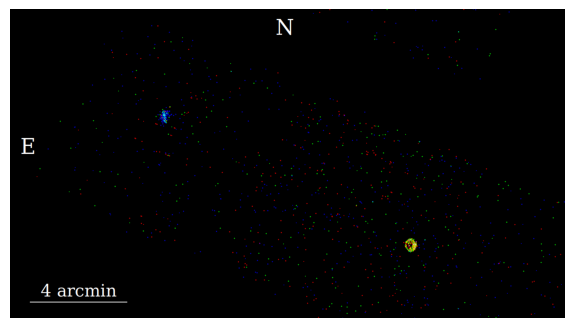

In [4]:
# === Image ===================================================================

# Load and display the image
img = plt.imread(root + image_file)
plt.imshow(img)
plt.axis('off')
plt.show()


ColDefs(
    name = 'TIME_BIN'; format = '1J'; unit = 'channel'
    name = 'TIME_MIN'; format = '1D'; unit = 's'; coord_type = 'DT_MIN'; coord_unit = 's'; coord_ref_point = 705930407.44746; coord_ref_value = 0.0; coord_inc = 1.0
    name = 'TIME'; format = '1D'; unit = 's'; coord_type = 'DT'; coord_unit = 's'; coord_ref_point = 705930407.44746; coord_ref_value = 0.0; coord_inc = 1.0
    name = 'TIME_MAX'; format = '1D'; unit = 's'; coord_type = 'DT_MAX'; coord_unit = 's'; coord_ref_point = 705930407.44746; coord_ref_value = 0.0; coord_inc = 1.0
    name = 'COUNTS'; format = '1J'; unit = 'count'
    name = 'STAT_ERR'; format = '1D'; unit = 'count'
    name = 'AREA'; format = '1D'; unit = 'pixel**2'
    name = 'EXPOSURE'; format = '1D'; unit = 's'
    name = 'COUNT_RATE'; format = '1D'; unit = 'count/s'
    name = 'COUNT_RATE_ERR'; format = '1D'; unit = 'count/s'
    name = 'BG_COUNTS'; format = '1D'; unit = 'count'
    name = 'BG_ERR'; format = '1D'; unit = 'count'
    name = 'BG_AREA';

/Users/steven/Desktop/harvard-paper/ml-xray-transients/src/utils/plotter.py:25: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(binned_time/1000, binned_counts, yerr=np.sqrt(binned_counts), fmt=fmt, color=color, ecolor=ecolor, capsize=capsize, markersize=markersize, linewidth=lwe, label=f'{bin_size}s Bins')


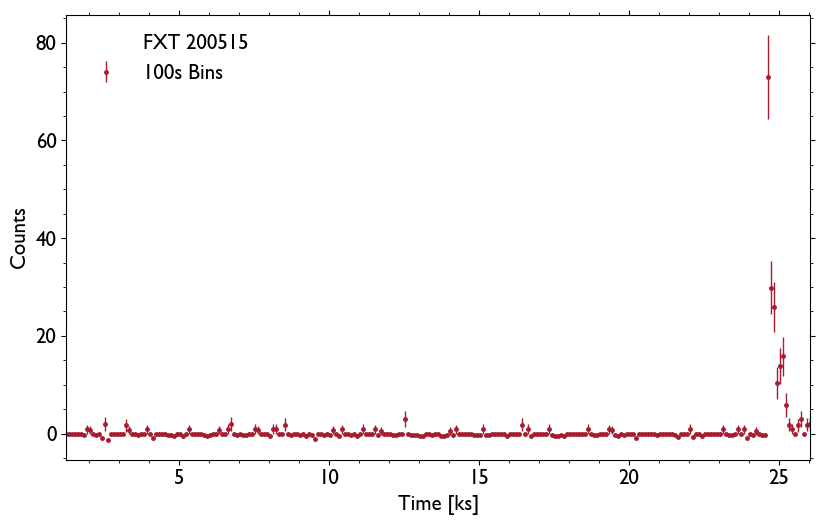

/Users/steven/Desktop/harvard-paper/ml-xray-transients/src/utils/plotter.py:19: RuntimeWarning: Mean of empty slice.
  binned_time = np.array([time[indices == i].mean() for i in range(1, len(bins))])
/Users/steven/anaconda3/envs/ml4fxt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


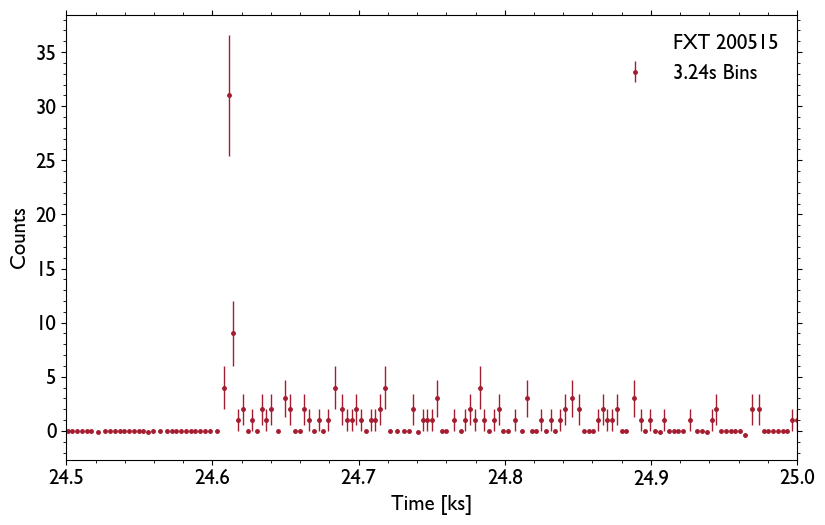

In [5]:
# === Lightcurve ==============================================================

# Load the lightcurve data
lc = fits.open(root + lc_file)
lc_data = lc[1].data
soft = fits.open(root + lc_soft)
soft_data = soft[1].data
hard = fits.open(root + lc_hard)
hard_data = hard[1].data

# Extract the data
time = lc_data['TIME']
counts = lc_data['COUNTS']
counts = lc_data['NET_COUNTS']
print(lc_data.columns)

# Plot full lightcurve
ax = lc_flare(time, counts, bin_size=100, color=harvard, ecolor=harvard, fmt='.', capsize=0, markersize=5, lwe=1, fontsize=15, title = 'XRT 200515')

# Zoom in on the flare
ax = lc_flare(time, counts, bin_size=3.24, color=harvard, ecolor=harvard, fmt='.', capsize=0, markersize=5, lwe=1, fontsize=15, title = 'XRT 200515', xlim=[24.5, 25])
# ax = lc_flare(flare_time, flare_counts, bin_size=3.24, color=harvard, ecolor=harvard, fmt='.', capsize=0, markersize=5, lwe=1, fontsize=15, title = 'FXT 200515')

In [6]:
# === Detailed Flare Analysis =================================================

# Find start of flare
idx_start = np.where(lc_data['COUNTS'] > 3)[0][0]
time_start = lc_data['TIME'][idx_start]
print('Flare start time:', time_start)

# Find end of flare (920s after start)
dur = 910 # CHOOSE THIS
idx_end = np.where(lc_data['TIME'] > lc_data['TIME'][idx_start] + dur)[0][0]
time_end = lc_data['TIME'][idx_end]
print('Flare end time:', time_end)

# Get flare counts
flare_counts = lc_data['COUNTS'][idx_start:idx_end]
flare_time = lc_data['TIME'][idx_start:idx_end]

# Find T90 
all_counts = np.sum(flare_counts)
idx_90 = np.where(np.cumsum(flare_counts) > 0.9 * all_counts)[0][0]
counts_90 = np.sum(flare_counts[:idx_90])
t90 = flare_time[idx_90] - flare_time[0]
print('All counts:', all_counts)
print('90% of counts:', counts_90)
print('T90:', t90)
idx_50 = np.where(np.cumsum(flare_counts) > 0.5 * all_counts)[0][0]
counts_50 = np.sum(flare_counts[:idx_50])
t50 = flare_time[idx_50] - flare_time[0]
print('50% of counts:', counts_50)
print('T50:', t50)

# Count rate to flux conversion
flare_counts = lc_data['NET_COUNTS'][idx_start:idx_end]
flare_count_rate = lc_data['NET_RATE'][idx_start:idx_end]

# Soft vs hard counts
soft_counts = soft_data['NET_COUNTS'][idx_start:idx_end]
hard_counts = hard_data['NET_COUNTS'][idx_start:idx_end]
soft_bkg = soft_data['BG_COUNTS'][idx_start:idx_end]
hard_bkg = hard_data['BG_COUNTS'][idx_start:idx_end]

# Background area ratios
source_area = lc_data['AREA'][0]
bg_area = lc_data['BG_AREA'][0]
print('Source area:', source_area)
print('Background area:', bg_area)
print('Ratio:', bg_area / source_area)

Flare start time: 705955015.24746
Flare end time: 705955925.6874601
All counts: 179
90% of counts: 161
T90: 531.3600000143051
50% of counts: 87
T50: 145.80000007152557
Source area: 3893.467724646917
Background area: 29456.827161180143
Ratio: 7.56570472504725


In [28]:
# === BEHR Hardness Ratio =====================================================

# Rebin data
binning = 10
rebinned_data = rebinning(flare_counts, flare_time, soft_counts, hard_counts, soft_bkg, hard_bkg,binning)
counts_new = rebinned_data['counts']
soft_counts_new = rebinned_data['soft_counts']
hard_counts_new = rebinned_data['hard_counts']
soft_bkg_new = rebinned_data['soft_bkg']
hard_bkg_new = rebinned_data['hard_bkg']
count_rate_new = rebinned_data['count_rate']
count_rate_err_new = rebinned_data['count_rate_err']
time_new = rebinned_data['time']
time_lo = rebinned_data['time_lo']
time_hi = rebinned_data['time_hi']

# Run BEHR
hr_result = behr_hr(behr_directory, root_directory + 'behr', soft_counts_new, hard_counts_new, soft_bkg_new, hard_bkg_new, bg_area / source_area)
hr = hr_result['hr']
hr_lo = hr_result['hr_lo']
hr_hi = hr_result['hr_hi']

# Flux Conversion Factor
avg_rate = 0.20815445633360044
avg_flux = 1.114096199200112e-11
flux_conversion = avg_flux / avg_rate
print('Flux Conversion Factor:', flux_conversion)


softsrc=0 hardsrc=35   softbkg=0   hardbkg=0 softarea=7.56570472504725 hardarea=7.56570472504725 outputPr=True algo=quad

#==========================================#
#           BEHR ver. 12-12-2013           #
#==========================================#
#      The Gibbs sampler is running.       #
#------------------------------------------#
# softsrc  =        0  hardsrc  =       35 #
# softbkg  =        0  hardbkg  =        0 #
# softarea =   7.5657  hardarea =   7.5657 #
#------------------------------------------#
# softeff  =        1  hardeff  =        1 #
# softidx  =      0.5  softscl  =        0 #
# hardidx  =      0.5  hardscl  =        0 #
# level    =       68  post     =    false #
# nsim     =    10000  nburnin  =     5000 #
#------------------------------------------#
#     A HPD interval will be computed.     #
# The outputs are placed in /Users/steven/Desktop/harvard-paper/ml-xray-transients/23022/behr/bin0.txt. #
#==========================================#
		Mode	

parameter names: ['amplitude', 'exponent']
independent variables: ['x']
parameter names: ['amplitude', 'alpha1', 'alpha2', 'x_break']
independent variables: ['x']
[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 14
    # variables        = 2
    chi-square         = 0.48304134
    reduced chi-square = 0.04025344
    Akaike info crit   = -43.1339452
    Bayesian info crit = -41.8558306
    R-squared          = 0.98101242
[[Variables]]
    amplitude:  1.42964515 +/- 0.10921458 (7.64%) (init = 0.1)
    exponent:  -0.29007970 +/- 0.01678160 (5.79%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = +0.8852
[[Model]]
    Model(broken_power_law)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 135
    # data points      = 14
    # variables        = 4
    chi-square         = 0.10417653
    reduced chi-square = 0.01041765
    Akaike in

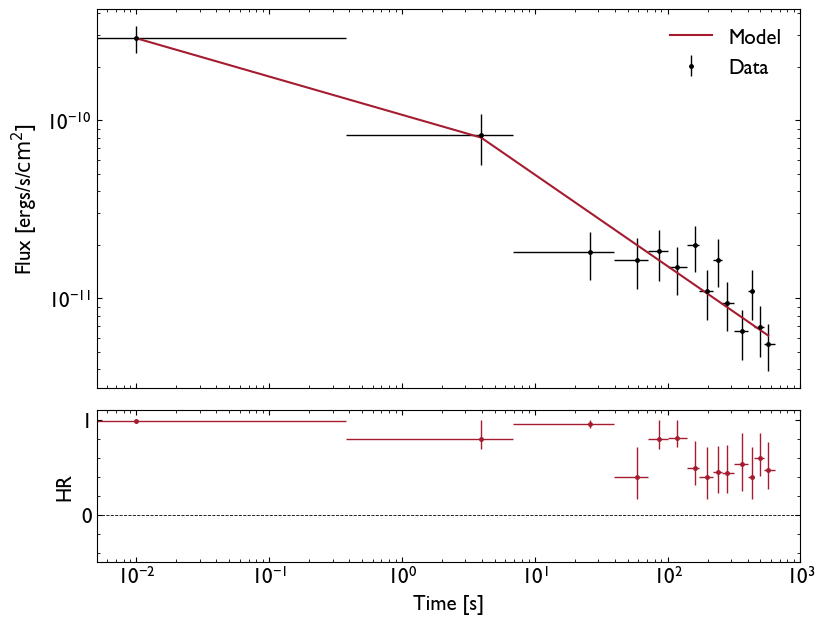

In [25]:
# === Broken Power Law Fit =====================================================
import powerlaw as pw
from lmfit import Model
from lmfit.models import powerlaw

# Define broken power law
def broken_power_law(x, amplitude, alpha1, alpha2, x_break):
    return amplitude * np.where(x < x_break, x ** alpha1, x ** alpha2)

def broken_power_law(x, amplitude, alpha1, alpha2, x_break):
    return np.piecewise(x, [x < x_break, x >= x_break], [lambda x: amplitude * (x ** alpha1), lambda x: amplitude * (x ** alpha2)])

# def broken_power_law(x, amplitude, alpha1, alpha2, x_break):
#     return np.piecewise(x, [x < x_break, x >= x_break],
#                         [lambda x: amplitude * (x ** alpha1), lambda x: amplitude * (x_break ** (alpha1 - alpha2)) * (x ** alpha2)])

# Define the data
x = time_new
x = np.array(x - time_new[0] + 0.01)
y = count_rate_new
y = count_rate_new 
y = np.array(y)
y_err = count_rate_err_new
x_lo = time_lo - time_new[0] + 0.01
x_hi = time_hi - time_new[0] + 0.01

# Define the power law model
pmodel = Model(powerlaw)
print(f'parameter names: {pmodel.param_names}')
print(f'independent variables: {pmodel.independent_vars}')

# Define the broken power law model
bpmodel = Model(broken_power_law)
print(f'parameter names: {bpmodel.param_names}')
print(f'independent variables: {bpmodel.independent_vars}')
# params = bpmodel.make_params()
# params = bpmodel.make_params(amplitude=0.1, alpha1=-1, alpha2=-1, x_break=x[1])

# Fit the model
result_p = pmodel.fit(y, x=x, amplitude=0.1, exponent=-1, constant=0.01)
print(result_p.fit_report())
result_bp = bpmodel.fit(y, x=x, amplitude=1, alpha1=0, alpha2=1, x_break=x[1])
print(result_bp.fit_report())
params_p = result_p.best_values
params_bp = result_bp.best_values

# Plot the results
lc_fit(x, y*flux_conversion, y_err*flux_conversion, result_bp.best_fit*flux_conversion, x_lo, x_hi, hr_results = hr_result, xlim = [0.005, 1000], color=harvard, ecolor='k', fontsize=15)